## Background

Since 2010, restaurants in New York City (NYC) have been required by the city's Health Department (HD) to physically post inspection grade signs outside of their front entrances. The inspection grade signs contain the most recent letter grade the restaurant received from a food inspection and look like this:

![NYC Inspection Grade Sign](images/nyc-inspection-sign.gif)

This requirement to post letter grades was enacted in an effort to improve food safety city-wide and to increase transparency of inspection information between the HD and the public. One of the goals of [a 2015 study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4330857/) into the impact of the posted letter grades in NYC was to determine whether they had an impact on diner behavior. A survey of New Yorkers was performed as part of that study and the results of the survey suggested that New Yorkers do factor in the posted letter grades when making dining decisions.

Since poor performance on food inspections can harm NYC restaurants financially, it's paramount that the inspection process contains no biases.

## Research Question/Hypothesis

I will be performing an analysis on food establishments in New York City and their food inspection results. The main research question I will be attempting to answer is:

> Is New York City's criteria for judging an establishment's food safety practices biased against food establishments that serve certain non-American cuisines?

With my hypothesis being:

> Food establishments that serve certain non-American cuisines typically receive worse inspection scores than their counterparts who serve American cuisine because there are specific violations that occur much more frequently while inspecting food establishments that serve certain non-American cuisines.

With the reason behind my hypothesis being that these specific violations occur much more frequently because of the methods necessary to prepare foods from certain non-American cuisines and not because of actual differences in food safety considerations. I believe I won't be able to support the reasoning behind my hypothesis or answer much of the research question I'm asking using the food inspection data alone. Further work would involve reaching out to experts in food safety, ethnic food preparation, or the [NYC Health Code](https://www1.nyc.gov/assets/doh/downloads/pdf/rii/article81-book.pdf) and linking more datasets to the one I'm using.

In [1]:
import matplotlib.pyplot
import numpy
import pandas
import requests
import scipy.stats

# to make sure no DataFrames being printed out to the console are truncated; large enough
# DataFrames are scrollable through jupyter but look like they are fully displayed through
# GitHub and nbviewer so I apologize for any inconvenience
pandas.set_option('display.max_rows', 100)

## Data

Through New York City's open data portal, [NYC Open Data](https://opendata.cityofnewyork.us/), they provide a [publically available, downloadable, frequently updated dataset](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j) consisting of the past three years of inspection results for each active restaurant, with the three years being from the most recent inspection for each restaurant. I wasn't able to find data licensing information in either NYC Open Data's [terms of use](https://opendata.cityofnewyork.us/overview/#termsofuse) or within NYC's [Open Data Law](https://opendata.cityofnewyork.us/open-data-law/). But, in the [FAQ section](https://opendata.cityofnewyork.us/faq/) of NYC Open Data's website, I found this question/answer:

> **Q:** Are there restrictions on how I can use Open Data?

> **A:** Open Data belongs to all New Yorkers. There are no restrictions on the use of Open Data. Refer to Terms of Use for more information.

From which I decided it was okay to use the NYC food inspection dataset they provided for my final project.


Since restaurant information, inspection information, and violation information are all contained in the same dataset, it looks a bit messy. Restaurants that have applied for a permit but have not yet been inspected are represented by a single row in the dataset. Inspections of restaurants that resulted in no violations are also represented by a single row in the dataset. All other rows in the dataset contain information about a single violation from a single inspection of a restaurant.

The schema for the food inspection dataset consists of 18 columns; here are the columns I utilized most with the descriptions/notes being summarized from the data dictionary that is listed as one of the attachments to the dataset through NYC's Open Data portal:

|Column|Description/Notes|
|:-----|:----------|
|CAMIS|unique identifier of a restaurant|
|BORO|NYC borough where restaurant is located|
|ZIPCODE|zip code where restaurant is located|
|CUISINE DESCRIPTION|cuisine type the restaurant serves, as optionally provided by the restaurant's owner/manager|
|INSPECTION DATE|date of inspection; "01/01/1900" is displayed for restaurants with no inspections|
|ACTION|action associated with each inspection|
|VIOLATION CODE|code of violation|
|VIOLATION DESCRIPTION|description of violation|
|CRITICAL FLAG|whether the violation is critical or not|
|SCORE|numerical score result of inspection that determines letter grade result; the lower the score, the better|
|GRADE|letter grade result of inspection|
|INSPECTION TYPE|a combination of the inspection program and type of inspection performed|

#### Reading/Downloading the Full Dataset into a DataFrame

In [2]:
# headers to allow the API to recognize me when requesting to download the dataset
my_headers = {
    "User-Agent": "https://github.com/ryanbald",
    "From": "baldr@uw.edu",
}

restaurant_inspection_results_csv_download = (
    "https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD"
)

response = requests.get(url=restaurant_inspection_results_csv_download, headers=my_headers)
with open("nyc_restaurant_inspection_results.csv", "wb") as f:
    f.write(response.content)

In [3]:
restaurant_inspection_results_df = pandas.read_csv(
    "nyc_restaurant_inspection_results.csv",
    dtype={"ZIPCODE": str},
    na_filter=False,
)

In [4]:
restaurant_inspection_results_df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,41076903,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,BRONX,1438,METROPOLITAN AVENUE,10462,7187929322,Caribbean,07/12/2016,Establishment Closed by DOHMH. Violations wer...,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,27,,,12/09/2018,Cycle Inspection / Initial Inspection
1,40513414,PADDY MAGUIRE'S ALE HOUSE,MANHATTAN,237,THIRD AVENUE,10003,2122530031,"Bottled beverages, including water, sodas, jui...",09/23/2015,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,21,B,09/23/2015,12/09/2018,Cycle Inspection / Re-inspection
2,41191561,GOURMET SWEETS,BROOKLYN,1107,CONEY ISLAND AVE,11230,7184214100,Pakistani,08/30/2018,Establishment Closed by DOHMH. Violations wer...,04M,Live roaches present in facility's food and/or...,Critical,53,,,12/09/2018,Cycle Inspection / Initial Inspection
3,41666477,CAFE TO GO,QUEENS,2858,32ND ST,11102,7187212848,American,05/18/2017,Violations were cited in the following area(s).,04O,Live animals other than fish in tank or servic...,Critical,5,A,05/18/2017,12/09/2018,Cycle Inspection / Initial Inspection
4,41676490,AOYU SUSHI,BRONX,3532,JOHNSON AVENUE,10463,7188846633,Japanese,04/12/2016,Violations were cited in the following area(s).,10I,"Single service item reused, improperly stored,...",Not Critical,9,A,04/12/2016,12/09/2018,Cycle Inspection / Initial Inspection


#### Creating a DataFrame of Restaurants

On top of the `CAMIS` column that is specifically meant to uniquely identify restaurants in the full food inspection dataset, I have identified other columns which I believe to be determined by the `CAMIS` column (i.e. for all inspections of a restaurant, the value of these columns will remain the same). Note that this DataFrame will contain _all_ restaurants in the full dataset, regardless of whether that restaurant has had an inspection or not.

In [5]:
restaurant_cols = [
    "CAMIS",
    "DBA",
    "BORO",
    "BUILDING",
    "STREET",
    "ZIPCODE",
    "PHONE",
    "CUISINE DESCRIPTION",
]

restaurants_df = restaurant_inspection_results_df[restaurant_cols].drop_duplicates()

The following assert statement is meant to verify the fact that the `CAMIS` column uniquely identifies a restaurant.

In [6]:
assert len(restaurants_df) == len(restaurants_df["CAMIS"].unique())

In [7]:
restaurants_df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION
0,41076903,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,BRONX,1438,METROPOLITAN AVENUE,10462,7187929322,Caribbean
1,40513414,PADDY MAGUIRE'S ALE HOUSE,MANHATTAN,237,THIRD AVENUE,10003,2122530031,"Bottled beverages, including water, sodas, jui..."
2,41191561,GOURMET SWEETS,BROOKLYN,1107,CONEY ISLAND AVE,11230,7184214100,Pakistani
3,41666477,CAFE TO GO,QUEENS,2858,32ND ST,11102,7187212848,American
4,41676490,AOYU SUSHI,BRONX,3532,JOHNSON AVENUE,10463,7188846633,Japanese


#### Creating a DataFrame of Inspections

I have identified columns which I believe to be consistent across all violations that occurred during the same inspection (i.e. columns that describe the inspection on the inspection-level). The `CAMIS` column is included in this list of columns to be the link between the restaurants DataFrame and the inspections DataFrame.

In [8]:
inspection_cols = [
    "CAMIS",
    "INSPECTION DATE",
    "INSPECTION TYPE",
    "SCORE",
    "GRADE",
    "ACTION",
    "GRADE DATE",
]

# explicitly ignore rows where the inspection date is "1/1/1900" as these rows represent
# restaurants that have yet to be inspected and not individual inspections, as mentioned
# earlier
inspections_df = restaurant_inspection_results_df[
    restaurant_inspection_results_df["INSPECTION DATE"] != "01/01/1900"
]

inspections_df = inspections_df[inspection_cols].drop_duplicates()

Here, I'm fishing for the _key_ of the inspections DataFrame; which columns in the DataFrame determine all other columns. This will be useful information to have when I'm constructing a violations DataFrame later and will be the link between the inspections DataFrame and the violations DataFrame. First, I'll check to see if the inspections key is (`CAMIS`, `INSPECTION DATE`, `INSPECTION TYPE`).

In [9]:
potential_inspection_key = ["CAMIS", "INSPECTION DATE", "INSPECTION TYPE"]

"{} = {}".format(
    len(inspections_df),
    len(inspections_df[potential_inspection_key].drop_duplicates()),
)

'146341 = 146333'

Since the inspections key is not (`CAMIS`, `INSPECTION DATE`, `INSPECTION TYPE`), I'll try adding the `SCORE` column to the key and see if that works.

In [10]:
potential_inspection_key.append("SCORE")

"{} = {}".format(
    len(inspections_df),
    len(inspections_df[potential_inspection_key].drop_duplicates()),
)

'146341 = 146341'

So, the inspections key is (`CAMIS`, `INSPECTION DATE`, `INSPECTION TYPE`, `SCORE`).

In [11]:
inspections_df.head()

,CAMIS,INSPECTION DATE,INSPECTION TYPE,SCORE,GRADE,ACTION,GRADE DATE
0,41076903,07/12/2016,Cycle Inspection / Initial Inspection,27,,Establishment Closed by DOHMH. Violations wer...,
1,40513414,09/23/2015,Cycle Inspection / Re-inspection,21,B,Violations were cited in the following area(s).,09/23/2015
2,41191561,08/30/2018,Cycle Inspection / Initial Inspection,53,,Establishment Closed by DOHMH. Violations wer...,
3,41666477,05/18/2017,Cycle Inspection / Initial Inspection,5,A,Violations were cited in the following area(s).,05/18/2017
4,41676490,04/12/2016,Cycle Inspection / Initial Inspection,9,A,Violations were cited in the following area(s).,04/12/2016


In [12]:
def group_by_count_and_show_ordered_results(df, column):
    """
    Given the inputted DataFrame (df) and which column to isolate (column),
    returns a DataFrame with all the unique values of a column, sorted by frequency.
    
    Is used to view the rough distribution of a column's values.
    """
    group_by_count_df = df[[column]].groupby(by=[column]).size().reset_index(name="COUNT")
    return group_by_count_df.sort_values("COUNT", ascending=False)

#### Considering How Inspection Type Affects Score

In [13]:
group_by_count_and_show_ordered_results(df=inspections_df, column="INSPECTION TYPE")

,INSPECTION TYPE,COUNT
9,Cycle Inspection / Initial Inspection,73785
10,Cycle Inspection / Re-inspection,35931
20,Pre-permit (Operational) / Initial Inspection,8927
1,Administrative Miscellaneous / Initial Inspection,6685
21,Pre-permit (Operational) / Re-inspection,4745
25,Smoke-Free Air Act / Initial Inspection,2853
11,Cycle Inspection / Reopening Inspection,2514
29,Trans Fat / Initial Inspection,2190
2,Administrative Miscellaneous / Re-inspection,2135
16,Pre-permit (Non-operational) / Initial Inspection,1706


As you can see, the NYC food inspection dataset provides 33 different inspection types. We only want to look at the inspection types that result in letter grades being posted by the restaurant's entrance since the results of these inspection types are what transitively becomes transparent to the customers. There is an "about" document that is linked as an attachment to the NYC food inspection dataset that provides this information. The document identifies the following inspection types as gradable inspection types (with my understanding of what each inspection type means):

|Inspection Type|Definition|
|:-------------:|:--------:|
|Pre-permit (Operational) / Initial Inspection|initial inspection to be done before a restaurant opens for business|
|Pre-permit (Operational) / Re-inspection|re-inspection to be done within a week of the pre-permit initial inspection if the restaurant did not pass the initial inspection (scored 14 or higher)|
|Cycle Inspection / Initial Inspection|initial inspection to be done within a year of the last inspection of the restaurant (the worse a restaurant fared during its last initial inspection, the shorter the time frame before the next initial inspection)|
|Cycle Inspection / Re-inspection|re-inspection to be done within a week of the cyclical initial inspection if the restaurant did not pass the initial inspection (scored 14 or higher)|

I will consider these gradable inspection types as two groups, initial inspections and re-inspections. The immediate hypothesis I have is re-inspections will have lower (better) inspection scores on average than initial inspections since they are initiated such a short time after the initial inspection and restaurant owners/managers know exactly where they need to improve because they are aware of where they were marked down during the initial inspection.

In [14]:
initial_inspections = [
    "Cycle Inspection / Initial Inspection",
    "Pre-permit (Operational) / Initial Inspection",
]
re_inspections = [
    "Cycle Inspection / Re-inspection",
    "Pre-permit (Operational) / Re-inspection"
]

initial_inspections_all_scores_df = inspections_df[
    (inspections_df["INSPECTION TYPE"] == initial_inspections[0]) |
    (inspections_df["INSPECTION TYPE"] == initial_inspections[1])
]
re_inspections_all_scores_df = inspections_df[
    (inspections_df["INSPECTION TYPE"] == re_inspections[0]) |
    (inspections_df["INSPECTION TYPE"] == re_inspections[1])
]

In [15]:
group_by_count_and_show_ordered_results(df=initial_inspections_all_scores_df, column="SCORE")

,SCORE,COUNT
21,12,9151
2,10,6490
25,13,6105
95,7,5129
117,9,4968
12,11,4631
73,5,3093
40,2,2738
106,8,2542
37,17,2329


In [16]:
group_by_count_and_show_ordered_results(df=re_inspections_all_scores_df, column="SCORE")

,SCORE,COUNT
8,12,6398
2,10,4481
9,13,4377
91,9,3431
5,11,3236
71,7,3103
49,5,1587
82,8,1498
16,2,1060
13,17,712


Of note from the distribution of inspection scores in both initial inspections (top) and re-inspections (bottom) is it's quite common for inspection scores to be right below the cutoff of a failing initial inspection/"B" letter grade re-inspection (all scores 13 or below are given the letter grade "A"). Possibly showing that the food inspectors are actually really nice. I won't be looking into this any further.

My minor takeaway is there appear to be 25 gradable inspections where the resulting score is -1, which could possibly skew the analysis that is to be done on these inspection scores. I will look into this a little bit further.

In [17]:
# converting the inspection score columns to integers to perform numerical analysis
initial_inspections_all_scores_df = initial_inspections_all_scores_df.astype({"SCORE": int})
re_inspections_all_scores_df = re_inspections_all_scores_df.astype({"SCORE": int})

In [18]:
initial_inspections_all_scores_df[initial_inspections_all_scores_df["SCORE"] == -1].head()

,CAMIS,INSPECTION DATE,INSPECTION TYPE,SCORE,GRADE,ACTION,GRADE DATE
7758,50074978,04/19/2018,Pre-permit (Operational) / Initial Inspection,-1,,Violations were cited in the following area(s).,
8195,50010285,07/15/2015,Cycle Inspection / Initial Inspection,-1,,Violations were cited in the following area(s).,
8282,41634218,05/23/2017,Cycle Inspection / Initial Inspection,-1,,Violations were cited in the following area(s).,
9733,50049103,09/05/2018,Cycle Inspection / Initial Inspection,-1,,Violations were cited in the following area(s).,
18295,50018381,10/16/2015,Pre-permit (Operational) / Initial Inspection,-1,,Violations were cited in the following area(s).,


I'm unsure as to what an inspection score of -1 represents, but it looks like it's not comparable to an inspection with a score of 0 since all of the inspections listed above contain violations (as seen in the `ACTION` column) and thereform should have positive inspection scores. I'll be ignoring inspections with a score of -1 in all further analysis.

In [19]:
# removing all inspections with a score of -1
initial_inspections_df = initial_inspections_all_scores_df[
    initial_inspections_all_scores_df["SCORE"] != -1
]
re_inspections_df = re_inspections_all_scores_df[re_inspections_all_scores_df["SCORE"] != -1]

In [20]:
initial_inspections_df["SCORE"].describe()

count    82693.000000
mean        15.964701
std         11.794587
min          0.000000
25%          9.000000
50%         12.000000
75%         20.000000
max        156.000000
Name: SCORE, dtype: float64

In [21]:
re_inspections_df["SCORE"].describe()

count    40670.000000
mean        13.105114
std          8.880548
min          0.000000
25%          9.000000
50%         11.000000
75%         13.000000
max        115.000000
Name: SCORE, dtype: float64

In [22]:
# Welch's t-test to compare population inspection score means between initial inspections and
# re-inspections
scipy.stats.ttest_ind(
    initial_inspections_df["SCORE"],
    re_inspections_df["SCORE"],
    equal_var=False,
)

Ttest_indResult(statistic=47.518766484145026, pvalue=0.0)

As hypothesized, re-inspections have significantly lower inspection scores than initial inspections. Instead of accounting for these differences, I will only be looking at initial inspections for all further analysis.

I have assumed that there is no difference in inspection scores between pre-permit initial inspections (pre-opening) and cyclical initial inspections.

In [23]:
# to show entire columns when printing DataFrames to the console
pandas.set_option('display.max_colwidth', -1)

#### Determining Which Ethnic Cuisines to Analyze

In [24]:
group_by_count_and_show_ordered_results(df=restaurants_df, column="CUISINE DESCRIPTION")

,CUISINE DESCRIPTION,COUNT
2,American,5944
19,Chinese,2434
13,CafÃ©/Coffee/Tea,1740
62,Pizza,1207
58,Other,1206
46,Italian,997
53,Mexican,936
47,Japanese,884
51,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",832
7,Bakery,736


Looking at the above distribution of restaurants by cuisine type, I will arbitrarily look at the top 7 ethnic cuisines by restaurant count (Chinese, Italian, Mexican, Japanese, Latin, Caribbean, and Spanish). I choose these ethnic cuisines because (a) they will presumably provide the highest inspection counts, (b) I didn't want to analyze too many ethnic cuisines at the same time, and (c) there seems to be a large gap between the number of Spanish restaurants and Indian restaurants, the next highest ethnic cuisine on the list.

In [25]:
main_cuisines = [
    "American",
    "Chinese",
    "Italian",
    "Mexican",
    "Japanese",
    "Latin",
    "Caribbean",
    "Spanish",
]

# allows for me to use the abbreviated form, "Latin", during further analysis while still
# filtering the restaurants DataFrame by the longer form that actually appears in the dataset
latin_cuisine_mapping = {
    "Latin": "Latin (Cuban, Dominican, Puerto Rican, South & Central American)",
}

In [26]:
def split_inspection_scores_by_group(column, groups, group_mappings={}):
    """
    Given a column from the restaurants DataFrame (column) and a list of possible values from
    that column (groups), returns a dictionary mapping each specified group to a list of
    initial inspection scores from restaurants in the specified group.
    
    Example parameters can be "CUISINE DESCRIPTION" as the column and a list of ethnic
    cuisines as the groups. This function would then return a dictionary mapping each ethnic
    cuisine to a list of initial inspection scores from restaurants that serve that ethnic
    cuisine.
    """
    inspection_scores_by_group = {}
    for group in groups:
        restaurants_by_group_df = restaurants_df[
            restaurants_df[column] == group_mappings.get(group, group)
        ]
        
        inspections_by_group_df = initial_inspections_df.merge(
            restaurants_by_group_df,
            on=["CAMIS"],
            suffixes=["", "dup"],
        )[inspection_cols]
        
        inspection_scores_by_group[group] = inspections_by_group_df[["SCORE"]]
        
    return inspection_scores_by_group

In [27]:
inspection_scores_by_cuisine = split_inspection_scores_by_group(
    column="CUISINE DESCRIPTION",
    groups=main_cuisines,
    group_mappings=latin_cuisine_mapping,
)

In [28]:
def create_inspection_score_cis_by_group(inspection_scores_by_group, groups):
    """
    Given a dictionary with lists of inspection scores as the values
    (inspection_scores_by_group) and a list of those keys (groups) to enforce an ordering,
    returns same-ordered lists of inspection score means and 95% confidence interval widths.
    
    The calculation of the 95% confidence interval width uses a t-statistic instead of a
    z-statistic because it is not assumed that the distribution of inspection scores is ever
    normal.
    
    Is used to produce the proper parameters to error bar plots that represent 95% confidence
    intervals.
    """
    # convert dictionary to list with the specified ordering enforced
    inspection_scores_by_group_list = [
        inspection_scores_by_group[group]["SCORE"] for group in groups
    ]
    
    inspection_score_means = numpy.array(
        [inspection_scores.mean() for inspection_scores in inspection_scores_by_group_list]
    )
    
    inspection_score_ci_widths = []
    for inspection_scores in inspection_scores_by_group_list:
        n = len(inspection_scores)
        std = inspection_scores.std()
        critical_t_value = scipy.stats.t.isf(q=0.025, df=n-1)
        inspection_score_ci_widths.append(critical_t_value*(std/numpy.sqrt(n)))
    inspection_score_ci_widths = numpy.array(inspection_score_ci_widths)
    
    return inspection_score_means, inspection_score_ci_widths

In [29]:
by_cuisine_means, by_cuisine_ci_widths = create_inspection_score_cis_by_group(
    inspection_scores_by_group=inspection_scores_by_cuisine,
    groups=main_cuisines,
)

#### Analyzing the Effect of Cuisine Type on Initial Inspection Scores

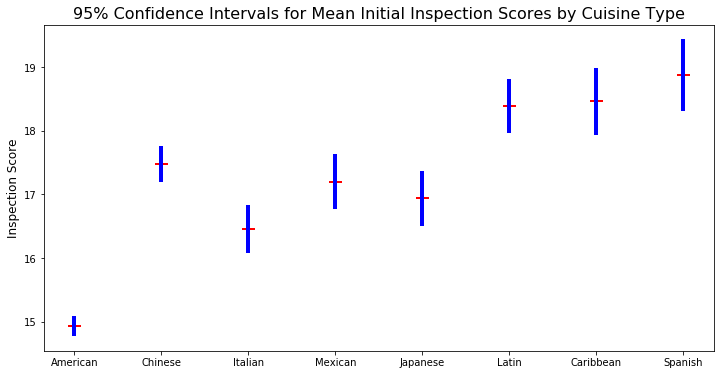

In [30]:
matplotlib.pyplot.figure(figsize=(12,6))
matplotlib.pyplot.errorbar(
    x=range(0,len(main_cuisines)),
    y=by_cuisine_means,
    xerr=0.075,
    ecolor="red",
    elinewidth=2,
    linestyle='',
)
matplotlib.pyplot.errorbar(
    x=main_cuisines,
    y=by_cuisine_means,
    yerr=by_cuisine_ci_widths,
    ecolor="blue",
    elinewidth=4,
    linestyle='',
)
matplotlib.pyplot.ylabel("Inspection Score", fontsize=12)
matplotlib.pyplot.title(
    "95% Confidence Intervals for Mean Initial Inspection Scores by Cuisine Type",
    fontsize=16,
)
matplotlib.pyplot.show()

In [31]:
t_statistics, p_values = [], []
for non_american_cuisine in main_cuisines[1:]:
    # Welch's t-test to compare population initial inspection score means between inspections
    # from restaurants that serve American cuisine and inspections from restaurants that serve
    # some ethnic cuisine
    t_statistic, p_value = scipy.stats.ttest_ind(
        inspection_scores_by_cuisine["American"],
        inspection_scores_by_cuisine[non_american_cuisine],
        equal_var=False,
    )
    # condense the resulting t-statistics and p-values from the t-test to display in a
    # DataFrame
    t_statistics.append(t_statistic[0])
    p_values.append(p_value[0])

In [32]:
# produce a DataFrame displaying the results of comparing each single ethnic cuisine type to
# the American cuisine type
t_test_results_data = {
    "Ethnic Cuisine": main_cuisines[1:],
    "P-Value": p_values,
    "T-Statistic": t_statistics,
}
t_test_results_df = pandas.DataFrame(data=t_test_results_data)
t_test_results_df.head(7)

,Ethnic Cuisine,P-Value,T-Statistic
0,Chinese,2.038988e-54,-15.607326
1,Italian,1.481604e-13,-7.411958
2,Mexican,1.767651e-22,-9.816079
3,Japanese,1.290000e-17,-8.591808
4,Latin,1.163003e-48,-14.866954
5,Caribbean,6.247772e-36,-12.697771
6,Spanish,1.822276e-38,-13.205889


As shown in both the plot of confidence intervals and DataFrame of statistical test results above, initial inspections of restaurants that serve American cuisine receive significantly better scores on average than initial inspections of restaurants that serve any of the ethnic cuisines I included in the analysis.

The first time through, at this point of my analysis, I thought I was finished. Research question answered. Hypothesis correct. Analysis done. But, this isn't enough. What else could be causing these results? What confounders out there could be affecting both the distribution of cuisine types and initial inspection scores? What other factors out there could be affecting initial inspection scores more than cuisine type?

#### Could Location in the Form of Borough be Affecting Inspection Scores?

It's possible that restaurant location could be affecting how a restaurant performs on their inspections. Poorer areas could have poorer restaurants and the NYC Health Code for food establishments could be written in such a way that it benefits restaurants that have more money, therefore being biased against restaurants that lack the same financial status.

The NYC inspection dataset provides a few fields that help denote location. I believe the restaurant's borough and zip code are worth further ananlysis. I will start big and look at the effects of borough on inspection scores first.

Since my knowledge of the qualities of each NYC borough is lacking, I will be referencing this Wikipedia page on the [Demographics of New York City](https://en.wikipedia.org/wiki/Demographics_of_New_York_City) for diversity and income for each borough. With a hypothesis that poorer boroughs are negatively affected by the inspection process in NYC, I'd expect the Bronx and Brooklyn to have higher initial inspection scores on average and Staten Island to have lower initial inspection scores on average.

In [33]:
group_by_count_and_show_ordered_results(df=restaurants_df, column="BORO")

,BORO,COUNT
2,MANHATTAN,10689
1,BROOKLYN,6690
4,QUEENS,6073
0,BRONX,2418
5,STATEN ISLAND,988
3,Missing,6


In [34]:
# ignoring restaurants that are missing a borough field
boroughs = ["MANHATTAN", "BROOKLYN", "QUEENS", "BRONX", "STATEN ISLAND"]

inspection_scores_by_borough = split_inspection_scores_by_group(
    column="BORO",
    groups=boroughs,
)
by_borough_means, by_borough_ci_widths = create_inspection_score_cis_by_group(
    inspection_scores_by_group=inspection_scores_by_borough,
    groups=boroughs,
)

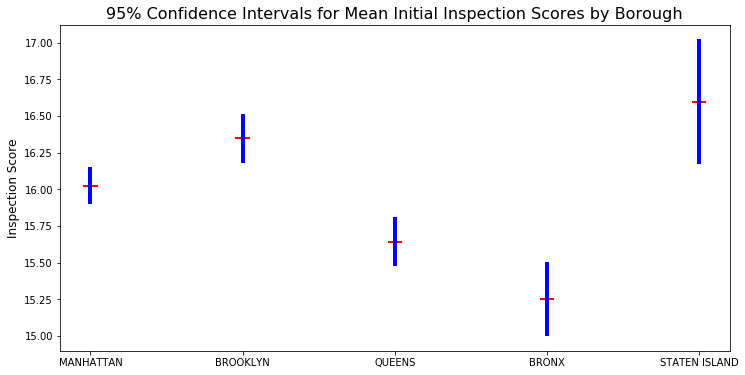

In [35]:
matplotlib.pyplot.figure(figsize=(12,6))
matplotlib.pyplot.errorbar(
    x=range(0,len(boroughs)),
    y=by_borough_means,
    xerr=0.047,
    ecolor="red",
    elinewidth=2,
    linestyle='',
)
matplotlib.pyplot.errorbar(
    x=boroughs,
    y=by_borough_means,
    yerr=by_borough_ci_widths,
    ecolor="blue",
    elinewidth=4,
    linestyle='',
)
matplotlib.pyplot.ylabel("Inspection Score", fontsize=12)
matplotlib.pyplot.title(
    "95% Confidence Intervals for Mean Initial Inspection Scores by Borough",
    fontsize=16,
)
matplotlib.pyplot.show()

For comparison between this plot and the last plot, notice the limits on the y-axis have changed. This plot looking at inspection scores by borough would take up roughly the bottom half of the previous plot looking at inspection score by cuisine.

As for my hypothesis, Brooklyn does look to be one of the worse performing boroughs when it comes to average initial inspection scores. But, the Bronx looks like the best and Staten Island looks like the worst, the complete opposite of what I stated in my hypothesis.

A more complete analysis on the potential of a restaurant's borough location to be a confounder in earlier conclusions made about the affects of cuisine type on initial inspection scores could include:
* plots looking at each borough individually and whether we see the same significant differences across mean initial inspection scores by cuisine type after accounting for borough
* plots looking at the distribution of cuisine types within each borough and see whether they are similar to the distribution of cuisine types throughout the whole of NYC

It could also be the case that borough is too general of a measure for location and there is too much variation in diversity and income within each borough. Going a level of granularity smaller and looking at the effects of zip code location of restaurant on initial inspection scores could reveal patterns not seen when looking at the borough-level.

#### Creating a DataFrame of Violations

In [36]:
violation_cols = [
    "CAMIS",
    "INSPECTION DATE",
    "INSPECTION TYPE",
    "SCORE",
    "VIOLATION CODE",
    "VIOLATION DESCRIPTION",
    "CRITICAL FLAG",
]

# for the violations DataFrame, we're including all violations from all initial inspections
# (even initial inspections that had a score a -1)
initial_violations_df = restaurant_inspection_results_df[
    ((restaurant_inspection_results_df["INSPECTION TYPE"] == initial_inspections[0]) |
     (restaurant_inspection_results_df["INSPECTION TYPE"] == initial_inspections[1])) &
    (restaurant_inspection_results_df["VIOLATION CODE"] != "")
][violation_cols]

In [37]:
potential_violation_key = [
    "CAMIS",
    "INSPECTION DATE",
    "INSPECTION TYPE",
    "SCORE",
    "VIOLATION CODE",
]

assert len(initial_violations_df) == len(
    initial_violations_df[potential_violation_key].drop_duplicates()
)

In [38]:
group_by_count_and_show_ordered_results(df=initial_violations_df, column="VIOLATION CODE")

,VIOLATION CODE,COUNT
60,10F,35284
49,08A,27169
42,06D,18765
28,04L,18207
41,06C,16881
6,02G,16026
56,10B,15100
1,02B,13977
30,04N,13902
24,04H,5955


In the [list of potential violations](https://www1.nyc.gov/assets/doh/downloads/pdf/rii/self-inspection-worksheet.pdf) provided by the NYC HD, it says only violations 02A-10J are scored and therefore contribute to the overall inspection score. I will therefore ignore all violation codes not in this range, though they probably weren't going to affect my analysis much anyway.

In [39]:
initial_violations_df = initial_violations_df[
    (initial_violations_df["VIOLATION CODE"] != "17A") &
    (initial_violations_df["VIOLATION CODE"] != "19A") &
    (initial_violations_df["VIOLATION CODE"] != "22F") &
    (initial_violations_df["VIOLATION CODE"] != "22G")
]

In [40]:
def get_violation_freq_for_cuisine(cuisine):
    """
    Given a cuisine type (cuisine), returns a DataFrame containing each violation that has
    occurred during an initial inspection of any restaurant that serves that cuisine and how
    frequent that violation occurs (i.e. percent of inspections where that violation was
    cited).
    """
    restaurants_for_cuisine = restaurants_df[restaurants_df["CUISINE DESCRIPTION"] == cuisine]
    
    # the number of initial inspections for restaurants that serve the specified cuisine
    # includes inspections that had no violations and inspections with a score of -1
    num_inspections_for_cuisine = len(initial_inspections_all_scores_df.merge(
        restaurants_for_cuisine,
        on=["CAMIS"],
    ))
    violations_for_cuisine = initial_violations_df.merge(
        restaurants_for_cuisine,
        on=["CAMIS"],
        suffixes=["", "dup"],
    )[violation_cols]
    violation_specific_cols = ["VIOLATION CODE", "VIOLATION DESCRIPTION", "CRITICAL FLAG"]
    violation_freq_for_cuisine = violations_for_cuisine[violation_specific_cols].groupby(
        by=violation_specific_cols,
    ).size().reset_index(name="FREQ")
    violation_freq_for_cuisine["FREQ"] = (
        violation_freq_for_cuisine["FREQ"]/num_inspections_for_cuisine
    )
    return violation_freq_for_cuisine.sort_values(by=["FREQ"], ascending=False)

#### Identifying Violations that are More Frequent in Ethnic Cuisines

In [41]:
american_violation_freq_df = get_violation_freq_for_cuisine("American")
american_violation_freq_df

,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,FREQ
59,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",Not Critical,0.428943
48,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,Not Critical,0.304269
41,06D,"Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.",Critical,0.283811
55,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepair or not functioning properly.,Not Critical,0.192972
40,06C,"Food not protected from potential source of contamination during storage, preparation, transportation, display or service.",Critical,0.187611
6,02G,Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above 38 ÂºF) except during necessary preparation.,Critical,0.187402
27,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.182197
29,04N,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facilitys food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.",Critical,0.180115
1,02B,Hot food item not held at or above 140Âº F.,Critical,0.114263
23,04H,"Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated, or not discarded in accordance with HACCP plan.",Critical,0.101770


In [42]:
chinese_violation_freq_df = get_violation_freq_for_cuisine("Chinese")
chinese_violation_freq_df

,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,FREQ
51,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",Not Critical,0.446731
40,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,Not Critical,0.349103
21,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.275066
34,06C,"Food not protected from potential source of contamination during storage, preparation, transportation, display or service.",Critical,0.263521
1,02B,Hot food item not held at or above 140Âº F.,Critical,0.259004
3,02G,Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above 38 ÂºF) except during necessary preparation.,Critical,0.236165
35,06D,"Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.",Critical,0.163258
47,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepair or not functioning properly.,Not Critical,0.134647
23,04N,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facilitys food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.",Critical,0.114067
22,04M,Live roaches present in facility's food and/or non-food areas.,Critical,0.104907


In [43]:
def get_top_differences_in_violation_freq(ethnic_cuisine_violation_freq_df, n=3):
    """
    Given a DataFrame containing violation type frequencies for a certain ethnic cuisine
    (ethnic_cuisine_violation_freq_df), returns a DataFrame displaying the top n (defaults to
    3) violation types based on how much more frequent they are in inspections of restaurants
    that serve the certain ethnic cuisine than they are in inspections of restaurants that
    serve American cuisine.
    """
    violation_freq_diffs = []
    for _, row in ethnic_cuisine_violation_freq_df.iterrows():
        violation_code = row["VIOLATION CODE"]
        violation_type = [
            violation_code,
            row["VIOLATION DESCRIPTION"],
            row["CRITICAL FLAG"]
        ]
        violation_freq = row["FREQ"]
        american_violation_freq_list = list(american_violation_freq_df[
            american_violation_freq_df["VIOLATION CODE"] == violation_code
        ]["FREQ"])
        
        # if the violation code hasn't appeared in any inspections of restaurants that serve
        # American cuisine, the frequency is 0
        american_violation_freq = 0
        if len(american_violation_freq_list) == 1:
            american_violation_freq = american_violation_freq_list[0]
            
        violation_freq_diffs.append(
            tuple(violation_type + [violation_freq, american_violation_freq])
        )

    top_violation_freq_diffs = sorted(violation_freq_diffs, key=lambda x: x[4] - x[3])[:n]
    return pandas.DataFrame.from_records(
        data=top_violation_freq_diffs,
        columns=["Code", "Description", "Criticality", "Frequency", "Frequency (American)"],
    )

In [44]:
get_top_differences_in_violation_freq(chinese_violation_freq_df)

,Code,Description,Criticality,Frequency,Frequency (American)
0,02B,Hot food item not held at or above 140Âº F.,Critical,0.259004,0.114263
1,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.275066,0.182197
2,06C,"Food not protected from potential source of contamination during storage, preparation, transportation, display or service.",Critical,0.263521,0.187611


As part of my research question's hypothesis, I suggested that restaurants that serve ethnic cuisines would perform worse on inspections because there are certain violations in the health code they are being judged against that are hard for them to avoid due to the nature of the ethnic cuisine being served. The example above shows the top three violations that occur in restaurants that serve Chinese cuisine based on how much more frequently they appear in Chinese restaurants than American restaurants. Violation 02B, "hot food item not held at or above 140F" occurs more than twice as often in Chinese restaurants than American restaurants. Why is this the case? Is there something specific to Chinese dishes that makes it hard for Chinese restaurants to avoid this violation? Did the NYC health code for food establishments consider all cuisines when defining that violation and its critical severity? All questions that could be asked about that violation.

On the other hand, the same questions probably can't be asked about the second violation on this list, violation 04L, "evidence of mice or live mice present in facility's food and/or non-food areas". The argument can't be made that live mice is something that's specifically needed for Chinese dishes. Interesting enough, restaurants that serve the ethnic cuisines I;ve included in my analysis receive this violation more frequently than restaurants that serve American cuisine.

In [45]:
get_top_differences_in_violation_freq(get_violation_freq_for_cuisine("Italian"), n=2)

,Code,Description,Criticality,Frequency,Frequency (American)
0,06C,"Food not protected from potential source of contamination during storage, preparation, transportation, display or service.",Critical,0.241232,0.187611
1,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.225374,0.182197


In [46]:
get_top_differences_in_violation_freq(get_violation_freq_for_cuisine("Mexican"), n=4)

,Code,Description,Criticality,Frequency,Frequency (American)
0,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,Not Critical,0.372797,0.304269
1,02H,"Food not cooled by an approved method whereby the internal product temperature is reduced from 140Âº F to 70Âº F or less within 2 hours, and from 70Âº F to 41Âº F or less within 4 additional hours.",Critical,0.089790,0.028891
2,04M,Live roaches present in facility's food and/or non-food areas.,Critical,0.085800,0.038730
3,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.225141,0.182197


In [47]:
get_top_differences_in_violation_freq(get_violation_freq_for_cuisine("Japanese"), n=2)

,Code,Description,Criticality,Frequency,Frequency (American)
0,02B,Hot food item not held at or above 140Âº F.,Critical,0.214259,0.114263
1,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.250657,0.182197


In [48]:
get_top_differences_in_violation_freq(get_violation_freq_for_cuisine(
    "Latin (Cuban, Dominican, Puerto Rican, South & Central American)"
), n=5)

,Code,Description,Criticality,Frequency,Frequency (American)
0,02B,Hot food item not held at or above 140Âº F.,Critical,0.280432,0.114263
1,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,Not Critical,0.395615,0.304269
2,04M,Live roaches present in facility's food and/or non-food areas.,Critical,0.117147,0.038730
3,04N,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facilitys food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.",Critical,0.237893,0.180115
4,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.231348,0.182197


In [49]:
get_top_differences_in_violation_freq(get_violation_freq_for_cuisine("Caribbean"), n=2)

,Code,Description,Criticality,Frequency,Frequency (American)
0,02B,Hot food item not held at or above 140Âº F.,Critical,0.345588,0.114263
1,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.369810,0.182197


In [50]:
get_top_differences_in_violation_freq(get_violation_freq_for_cuisine("Spanish"), n=3)

,Code,Description,Criticality,Frequency,Frequency (American)
0,02B,Hot food item not held at or above 140Âº F.,Critical,0.311676,0.114263
1,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,Not Critical,0.382022,0.304269
2,04L,Evidence of mice or live mice present in facility's food and/or non-food areas.,Critical,0.256961,0.182197


New York City has a lot of mice, so I hear. Maybe this pattern is one of the ways a restaurant's location is affecting its inspection scores.

## Non-linked Sources

* https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf

* https://www1.nyc.gov/nyc-resources/service/2363/restaurant-letter-grading

* https://www.foodsafetynews.com/2010/03/new-york-city-to-grade-restaurants/